In [2]:
'''
SOURCE TAKEN FROM: https://fairyonice.github.io/Achieving-top-5-in-Kaggles-facial-keypoints-detection-using-FCN.html
'''
from IPython.display import IFrame
src = "https://www.youtube.com/embed/8FdSHl4oNIM"
IFrame(src, width=990/2, height=800/2)
import sys, os
print(os.path.dirname(sys.executable))
print(sys.version)

/home1/irteam/notebook/jinmoku_notebook/.env/bin
3.6.5 (default, Apr 10 2018, 17:08:37) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import _get_available_gpus
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout
print(tf.__version__)
'''
아래 함수를 실행할 경우, 모든 gpu를 가져와서 실행하게된다.
'''
#print(_get_available_gpus())

'''
아래는 특정 gpu만 실행.
'''
# # device_count = {'GPU': 1 , 'CPU': 56}
# config = tf.ConfigProto(log_device_placement = True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# #### GPU0~8
# config.gpu_options.visible_device_list = "0,1"
# set_session(tf.Session(config=config))

FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
FIdLookup = 'data/IdLookupTable.csv'

1.9.0


Using TensorFlow backend.


In [26]:
def load(test=False, cols=None):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X: 2-d numpy array (Nsample, Ncol*Nrow)
    y: 2-d numpy array (Nsample, Nlandmarks*2) 
       In total there are 15 landmarks. 
       As x and y coordinates are recorded, u.shape = (Nsample,30)
       
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  
        df = df[list(cols) + ['Image']]

    myprint = df.count()
    myprint = myprint.reset_index()
    
    ## row with at least one NA columns are removed!
    df = df.dropna()  
    
    # changes valeus between 0 and 1. [0, 255] -> [0, 1]. 나중에 image display시 필요.
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        ## standardization of the response
        y = df[df.columns[:-1]].values
        # y values are between [-1,1]. 변환과정: [0, 96] -> [-48, 48] -> [-1, 1]
        y = (y - 48) / 48  
        y = y.astype(np.float32)
        X, y = shuffle(X, y, random_state=42)  # shuffle data
    else:
        y = None
    
    
    return X, y

def load2d(test=False, cols=None):

    X, y = load(test, cols)
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
    # -1 은 알아서 유추.
    # (*, 9216) -> (*, 96, 96, 1)
    X = X.reshape(-1, 96, 96, 1)

    return X, y

def plot_loss(hist, name, plt, RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        # multiply by 48 to get the loss in the original scale. + 48 is not necessary since it's canceled out.
        loss = np.sqrt(np.array(loss)) * 48 
        val_loss = np.sqrt(np.array(val_loss)) * 48 
        
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
    plt.plot(loss,"--", linewidth=3, label="train:%s" % name)
    plt.plot(val_loss, ':', linewidth=3, label="val: %s" % name)
    
def plot_sample(X, y, axs, color='b'):
    '''
    X: 9216 -> 96 by 96 Image
    y: feature values rescaled to range between -1 and 1
    '''
    # show image
    axs.imshow(X.reshape(96, 96), cmap="gray")
    '''
    https://docs.python.org/release/2.3.5/whatsnew/section-slices.html
    y[0::2] -> y[0], y[2], y[4], y[6], y[8] ...
    y[1::2] -> y[1], y[3], y[5], y[7], y[9] ...
    '''
    # scatter plot of feature points
    axs.scatter(48 * y[0::2] + 48, 48 * y[1::2] + 48, c=color)
    
def save_model(model, hist, name):
    '''
    save model architecture and model weights
    '''
    json_string = model.to_json()
    with open('models/%s_architecture.json' % name, 'w') as model_f:
        model_f.write(json_string)
    model.save_weights('models/%s_weights.h5' % name)
    
    with open('history/%s.history' % name, 'wb') as hist_f:
        pickle.dump(hist, hist_f)
    
def load_model(name):
    model_f = open('models/%s_architecture.json' % name)
    model = model_from_json(model_f.read())
    model.load_weights('models/%s_weights.h5' % name)
    model_f.close()
    
    with open('history/%s.history' % name, 'rb') as hist_f:
        history = pickle.load(hist_f)
    return model, history

In [30]:
'''
X.shape = <2140(= number of samples pruned), 9216(= 96*96 = number of image pixels)>
Y.shape = <2140(= number of samples pruned), 30(= number of attributes = 15 facialpoints * 2(xy 좌표 각각 1개씩))>
'''
X, y = load()
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html
print("X type: %s, y type: %s" % (type(X), type(y)))
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X[0]: %s" % str(X[0]))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("y[0]: %s" % str(y[0]))

X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
X[0]: [0.79607844 0.7058824  0.59607846 ... 0.11372549 0.14901961 0.17254902]
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996
y[0]: [ 0.3816111  -0.21757638 -0.40208334 -0.21338195  0.21397223 -0.20919445
  0.56600696 -0.21338195 -0.20930555 -0.2008125  -0.5739097  -0.18404861
  0.167875   -0.37682638  0.6707778  -0.33072916 -0.16739583 -0.37263888
 -0.70382637 -0.23852777  0.03376389  0.22246528  0.4193264   0.5116389
 -0.38531944  0.5158264   0.02538195  0.4403889   0.03376389  0.8259514 ]


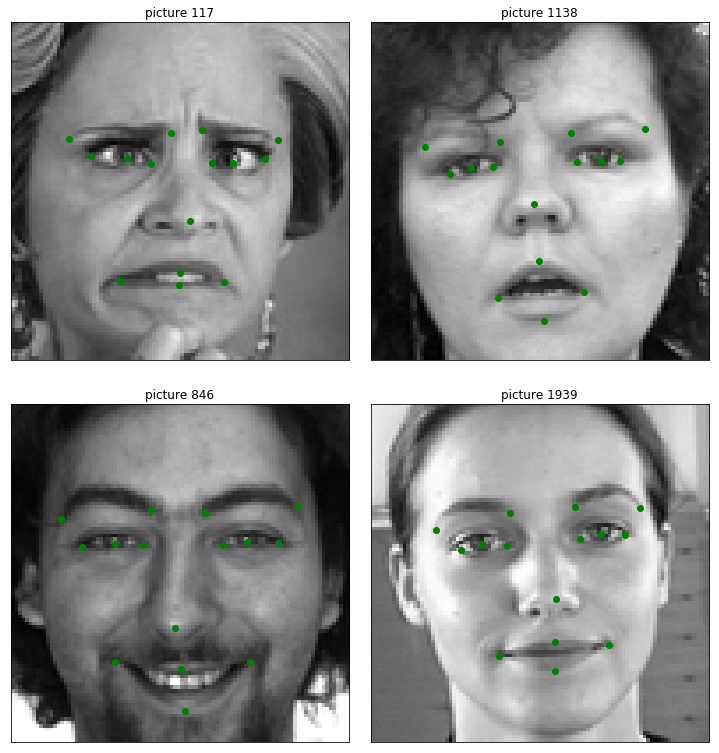

In [17]:
# https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 4
count = 1
# show images randomly in a 2X2 grid
for irow in range(Npicture):
    ipic = np.random.choice(X.shape[0])
    # https://matplotlib.org/api/axes_api.html
    axs = fig.add_subplot(Npicture/2, 2, count, xticks=[], yticks=[])
    # plot an image and its features
    plot_sample(X[ipic], y[ipic], axs, color='g')
    axs.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [31]:
%%time

def SimpleNN():
    # Sequential Model: a linear stack of neural network layers.
    model = Sequential()
    '''
    Add NN layer: (2140, 9216) -> (2140, 100)
    '''
    model.add(Dense(100, input_dim=X.shape[1]))
    '''
    Add Activation layer: (2140, 100) -> (2140, 100)
    '''
    model.add(Activation('relu'))
    '''
    Add NN layer: (2140, 100) -> (2140, 30)
    '''
    model.add(Dense(30))

    '''
    Optimizer SGD: 
        learning rate: 0.01
        momentum: 0.9
        apply Nesterov momentum: true
    Loss Function: MSE
    '''
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model

'''
Train the model.
validation_split -> use 20% of the training data for evaluation after each epoch
history.history -> loss, val_loss(validation loss)
'''
model = SimpleNN()
hist = model.fit(X, y, epochs=1000, validation_split=0.2, verbose=1)

# save model
save_model(model, hist.history, "BasicNN")

Train on 1712 samples, validate on 428 samples
Epoch 1/1000
1712/1712 [==============================] - 1s 326us/step - loss: 0.0848 - val_loss: 0.0127
Epoch 2/1000
1712/1712 [==============================] - 0s 90us/step - loss: 0.0115 - val_loss: 0.0103
Epoch 3/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0092 - val_loss: 0.0091
Epoch 5/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0087 - val_loss: 0.0096
Epoch 6/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0083 - val_loss: 0.0084
Epoch 7/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0079 - val_loss: 0.0077
Epoch 8/1000
1712/1712 [==============================] - 0s 82us/step - loss: 0.0075 - val_loss: 0.0078
Epoch 9/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0072 - val_loss: 0.0074
Epoch 1

Epoch 78/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 79/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 80/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 81/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0028 - val_loss: 0.0037
Epoch 82/1000
1712/1712 [==============================] - 0s 90us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 83/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 84/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 85/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 86/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 87/1000
1712/1712 [=====================

Epoch 155/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 156/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 157/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0019 - val_loss: 0.0031
Epoch 158/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 159/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 160/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 161/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0019 - val_loss: 0.0032
Epoch 162/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 163/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 164/1000
1712/1712 [===========

1712/1712 [==============================] - 0s 83us/step - loss: 0.0017 - val_loss: 0.0030
Epoch 232/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0016 - val_loss: 0.0028
Epoch 233/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0016 - val_loss: 0.0028
Epoch 234/1000
1712/1712 [==============================] - 0s 82us/step - loss: 0.0017 - val_loss: 0.0028
Epoch 235/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0016 - val_loss: 0.0028
Epoch 236/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 237/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0016 - val_loss: 0.0031
Epoch 238/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0017 - val_loss: 0.0028
Epoch 239/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0016 - val_loss: 0.0028
Epoch 240/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 89us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 308/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 309/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 310/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 311/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 312/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 313/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 314/1000
1712/1712 [==============================] - 0s 91us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 315/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 316/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 384/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 385/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 386/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 387/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 388/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 389/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 390/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 391/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 392/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 87us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 460/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 461/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 462/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0026
Epoch 463/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 464/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 465/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 466/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0028
Epoch 467/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0013 - val_loss: 0.0027
Epoch 468/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 0.0028
Epoch 536/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 537/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 538/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 539/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 540/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 541/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 542/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 543/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 544/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 612/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 613/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 614/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 615/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 616/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0012 - val_loss: 0.0027
Epoch 617/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 618/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 619/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 620/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 84us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 688/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 689/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 690/1000
1712/1712 [==============================] - 0s 88us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 691/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 692/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 693/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 694/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 695/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 696/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 764/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 765/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 766/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 767/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0028
Epoch 768/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 769/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 770/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 771/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 772/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 840/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 841/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 842/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 843/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 844/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 845/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0011 - val_loss: 0.0028
Epoch 846/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 847/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 848/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 84us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 916/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 917/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 918/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 919/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 920/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 921/1000
1712/1712 [==============================] - 0s 83us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 922/1000
1712/1712 [==============================] - 0s 89us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 923/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 924/1000
1712/1712 [==========================

1712/1712 [==============================] - 0s 86us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 992/1000
1712/1712 [==============================] - 0s 85us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 993/1000
1712/1712 [==============================] - 0s 84us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 994/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 995/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 996/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 997/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 998/1000
1712/1712 [==============================] - 0s 86us/step - loss: 0.0010 - val_loss: 0.0028
Epoch 999/1000
1712/1712 [==============================] - 0s 87us/step - loss: 0.0010 - val_loss: 0.0027
Epoch 1000/1000
1712/1712 [=========================

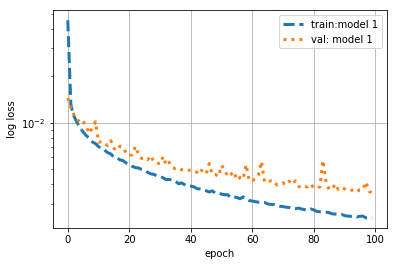

In [11]:
# reload model
model1, history1 = load_model("BasicNN")

plot_loss(history1, "model 1", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [12]:
# reload model
model1, history1 = load_model("BasicNN")

# load X from test dataset
X_test , _ = load(test=True)
y_test = model1.predict(X_test)
print("X_test type: %s, y_test type: %s" % (type(X_test), type(y_test)))
print("X_test.shape == {}; X_test.min == {:.3f}; X_test.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))
print("y_test.shape == {}; y_test.min == {:.3f}; y_test.max == {:.3f}".format(y_test.shape, y_test.min(), y_test.max()))

X_test type: <class 'numpy.ndarray'>, y_test type: <class 'numpy.ndarray'>
X_test.shape == (1783, 9216); X_test.min == 0.000; X_test.max == 1.000
y_test.shape == (1783, 30); y_test.min == -0.919; y_test.max == 1.118


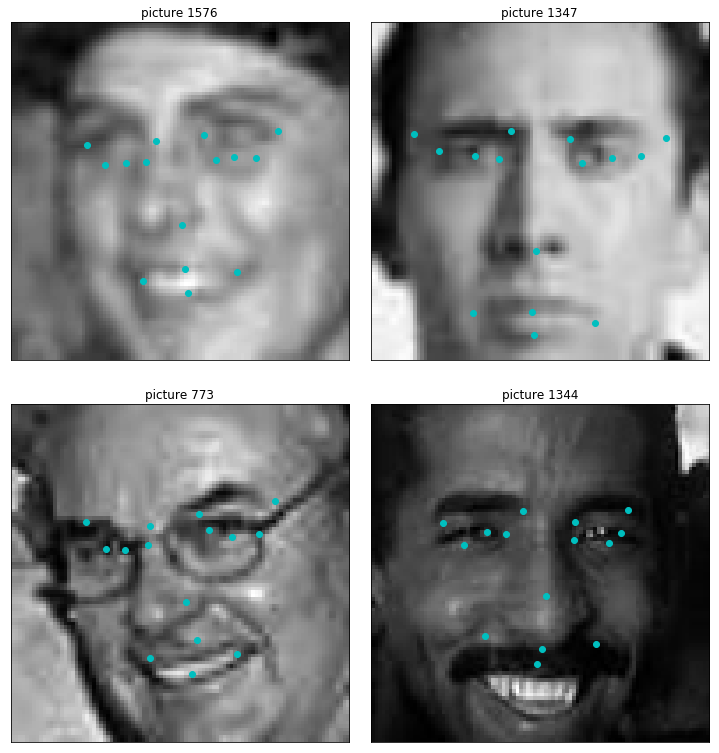

In [13]:
# https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.13, wspace=0.0001, left=0, right=1, bottom=0, top=1)
Npicture = 4
count = 1
# show images randomly in a 2X2 grid
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    # https://matplotlib.org/api/axes_api.html
    axs = fig.add_subplot(Npicture/2, 2, count, xticks=[], yticks=[])
    # plot an image and its features
    plot_sample(X_test[ipic], y_test[ipic], axs, color = 'c')
    axs.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [21]:
# load data as 2-dim
X, y = load2d()
print("X type: %s, y type: %s" % (type(X), type(y)))
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X[0]: %s" % str(X[0]))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("y[0]: %s" % str(y[0]))

X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X.shape == (2140, 96, 96, 1); X.min == 0.000; X.max == 1.000
X[0]: [[[0.79607844]
  [0.7058824 ]
  [0.59607846]
  ...
  [0.11372549]
  [0.12156863]
  [0.14117648]]

 [[0.8117647 ]
  [0.8235294 ]
  [0.6392157 ]
  ...
  [0.11764706]
  [0.13333334]
  [0.14901961]]

 [[0.8117647 ]
  [0.69803923]
  [0.42745098]
  ...
  [0.13333334]
  [0.11764706]
  [0.14117648]]

 ...

 [[0.10980392]
  [0.10588235]
  [0.10196079]
  ...
  [0.12156863]
  [0.11764706]
  [0.14117648]]

 [[0.10980392]
  [0.10980392]
  [0.10588235]
  ...
  [0.11764706]
  [0.13333334]
  [0.15686275]]

 [[0.12156863]
  [0.11764706]
  [0.11372549]
  ...
  [0.11372549]
  [0.14901961]
  [0.17254902]]]
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996
y[0]: [ 0.3816111  -0.21757638 -0.40208334 -0.21338195  0.21397223 -0.20919445
  0.56600696 -0.21338195 -0.20930555 -0.2008125  -0.5739097  -0.18404861
  0.167875   -0.37682638  0.6707778  -0.33072916 -0.16739583 -0.372

In [22]:
%%time
def SimpleCNN(withDropout=False):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    # https://keras.io/layers/convolutional/
    '''
    Conv Layer: 32 Filters w/ 3X3 window
    Input Layer: 96 X 96 X 1 Image (X.shape == (*, 96, 96, 1))
    
    O = Output heigth(width)
    W = Input height(Width)
    K = Filter height(width)
    P = Padding
    S = Stride
    =====================================
        O = (W - K + 2P) / S + 1
    =====================================
    
    -> (96 - 3 + 2*0) / 1 + 1 = 94
    shape = (*, 94, 94, 32)
    '''
    model.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
    model.add(Activation('relu'))
    
    # https://keras.io/layers/pooling/
    '''
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
    
    -> 94 / 2 = 47
    shape = (*, 47, 47, 32)
    '''
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    '''
    -> (47 - 2 + 2*0) / 1 + 1 = 46
    shape = (*, 46, 46, 64)
    '''
    model.add(Conv2D(64, (2, 2)))
    model.add(Activation('relu'))
    '''
    -> 46 / 2 = 23
    shape = (*, 23, 23, 64)
    '''
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    '''
    -> (23 - 2 + 2*0) / 1 + 1 = 22
    shape = (*, 22, 22, 128)
    '''
    model.add(Conv2D(128, (2, 2)))
    model.add(Activation('relu'))
    '''
    -> 22 / 2 = 11
    shape = (*, 11, 11, 128)
    '''
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    '''
    -> 11 * 11 * 128 = 15488
    shape = (*, 15488)
    '''
    model.add(Flatten())
    
    '''
    shape = (*, 500)
    '''
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
    
    '''
    shape = (*, 500)
    '''
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
    
    '''
    shape = (*, 30)
    '''
    model.add(Dense(30))
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss="mean_squared_error", optimizer=sgd)
    return(model)

# Use gpu

model = SimpleCNN()
hist = model.fit(X, y, epochs=1000, validation_split=0.2, verbose=1)

# save model
save_model(model, hist.history, "BasicCNN")


Train on 1712 samples, validate on 428 samples
Epoch 1/1000
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0398 - val_loss: 0.0068
Epoch 2/1000
1712/1712 [==============================] - 1s 342us/step - loss: 0.0066 - val_loss: 0.0059
Epoch 3/1000
1712/1712 [==============================] - 1s 342us/step - loss: 0.0059 - val_loss: 0.0054
Epoch 4/1000
1712/1712 [==============================] - 1s 342us/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/1000
1712/1712 [==============================] - 1s 342us/step - loss: 0.0051 - val_loss: 0.0049
Epoch 6/1000
1712/1712 [==============================] - 1s 341us/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/1000
1712/1712 [==============================] - 1s 341us/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/1000
1712/1712 [==============================] - 1s 341us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/1000
1712/1712 [==============================] - 1s 347us/step - loss: 0.0045 - val_loss: 0.0045
E

1712/1712 [==============================] - 1s 338us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 78/1000
1712/1712 [==============================] - 1s 339us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 79/1000
1712/1712 [==============================] - 1s 339us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 80/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 81/1000
1712/1712 [==============================] - 1s 339us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 82/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 83/1000
1712/1712 [==============================] - 1s 342us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 84/1000
1712/1712 [==============================] - 1s 336us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 85/1000
1712/1712 [==============================] - 1s 344us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 86/1000
1712/1712 [==========================

1712/1712 [==============================] - 1s 334us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 154/1000
1712/1712 [==============================] - 1s 333us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 155/1000
1712/1712 [==============================] - 1s 333us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 156/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 157/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 158/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 159/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 160/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 161/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 162/1000
1712/1712 [=================

Epoch 229/1000
1712/1712 [==============================] - 1s 340us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 230/1000
1712/1712 [==============================] - 1s 336us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 231/1000
1712/1712 [==============================] - 1s 339us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 232/1000
1712/1712 [==============================] - 1s 338us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 233/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 234/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 235/1000
1712/1712 [==============================] - 1s 338us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 236/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 237/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 238/1000
1712/1712 [==

Epoch 305/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 306/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 307/1000
1712/1712 [==============================] - 1s 343us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 308/1000
1712/1712 [==============================] - 1s 334us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 309/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 310/1000
1712/1712 [==============================] - 1s 336us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 311/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 312/1000
1712/1712 [==============================] - 1s 336us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 313/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 314/1000
1712/1712 [==

Epoch 381/1000
1712/1712 [==============================] - 1s 336us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 382/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 383/1000
1712/1712 [==============================] - 1s 347us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 384/1000
1712/1712 [==============================] - 1s 339us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 385/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 386/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 387/1000
1712/1712 [==============================] - 1s 337us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 388/1000
1712/1712 [==============================] - 1s 336us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 389/1000
1712/1712 [==============================] - 1s 335us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 390/1000
1712/1712 [==

1712/1712 [==============================] - 1s 337us/step - loss: 8.8450e-04 - val_loss: 0.0015
Epoch 455/1000
1712/1712 [==============================] - 1s 340us/step - loss: 8.8241e-04 - val_loss: 0.0015
Epoch 456/1000
1712/1712 [==============================] - 1s 337us/step - loss: 8.8350e-04 - val_loss: 0.0015
Epoch 457/1000
1712/1712 [==============================] - 1s 339us/step - loss: 8.7788e-04 - val_loss: 0.0015
Epoch 458/1000
1712/1712 [==============================] - 1s 341us/step - loss: 8.7730e-04 - val_loss: 0.0015
Epoch 459/1000
1712/1712 [==============================] - 1s 343us/step - loss: 8.7660e-04 - val_loss: 0.0015
Epoch 460/1000
1712/1712 [==============================] - 1s 336us/step - loss: 8.7320e-04 - val_loss: 0.0015
Epoch 461/1000
1712/1712 [==============================] - 1s 337us/step - loss: 8.7426e-04 - val_loss: 0.0015
Epoch 462/1000
1712/1712 [==============================] - 1s 337us/step - loss: 8.7163e-04 - val_loss: 0.0015
Epoch 4

1712/1712 [==============================] - 1s 335us/step - loss: 7.7819e-04 - val_loss: 0.0015
Epoch 528/1000
1712/1712 [==============================] - 1s 336us/step - loss: 7.7613e-04 - val_loss: 0.0014
Epoch 529/1000
1712/1712 [==============================] - 1s 335us/step - loss: 7.7485e-04 - val_loss: 0.0014
Epoch 530/1000
1712/1712 [==============================] - 1s 337us/step - loss: 7.7385e-04 - val_loss: 0.0014
Epoch 531/1000
1712/1712 [==============================] - 1s 341us/step - loss: 7.7173e-04 - val_loss: 0.0015
Epoch 532/1000
1712/1712 [==============================] - 1s 337us/step - loss: 7.7158e-04 - val_loss: 0.0015
Epoch 533/1000
1712/1712 [==============================] - 1s 335us/step - loss: 7.7095e-04 - val_loss: 0.0014
Epoch 534/1000
1712/1712 [==============================] - 1s 341us/step - loss: 7.6986e-04 - val_loss: 0.0015
Epoch 535/1000
1712/1712 [==============================] - 1s 337us/step - loss: 7.6709e-04 - val_loss: 0.0014
Epoch 5

1712/1712 [==============================] - 1s 334us/step - loss: 6.9226e-04 - val_loss: 0.0014
Epoch 601/1000
1712/1712 [==============================] - 1s 334us/step - loss: 6.8919e-04 - val_loss: 0.0014
Epoch 602/1000
1712/1712 [==============================] - 1s 337us/step - loss: 6.8765e-04 - val_loss: 0.0014
Epoch 603/1000
1712/1712 [==============================] - 1s 335us/step - loss: 6.8781e-04 - val_loss: 0.0014
Epoch 604/1000
1712/1712 [==============================] - 1s 335us/step - loss: 6.8709e-04 - val_loss: 0.0014
Epoch 605/1000
1712/1712 [==============================] - 1s 335us/step - loss: 6.8623e-04 - val_loss: 0.0014
Epoch 606/1000
1712/1712 [==============================] - 1s 335us/step - loss: 6.8412e-04 - val_loss: 0.0014
Epoch 607/1000
1712/1712 [==============================] - 1s 340us/step - loss: 6.8260e-04 - val_loss: 0.0014
Epoch 608/1000
1712/1712 [==============================] - 1s 337us/step - loss: 6.8137e-04 - val_loss: 0.0014
Epoch 6

1712/1712 [==============================] - 1s 337us/step - loss: 6.1849e-04 - val_loss: 0.0014
Epoch 674/1000
1712/1712 [==============================] - 1s 339us/step - loss: 6.1815e-04 - val_loss: 0.0014
Epoch 675/1000
1712/1712 [==============================] - 1s 338us/step - loss: 6.1615e-04 - val_loss: 0.0014
Epoch 676/1000
1712/1712 [==============================] - 1s 339us/step - loss: 6.1714e-04 - val_loss: 0.0014
Epoch 677/1000
1712/1712 [==============================] - 1s 336us/step - loss: 6.1359e-04 - val_loss: 0.0014
Epoch 678/1000
1712/1712 [==============================] - 1s 338us/step - loss: 6.1446e-04 - val_loss: 0.0014
Epoch 679/1000
1712/1712 [==============================] - 1s 339us/step - loss: 6.1217e-04 - val_loss: 0.0014
Epoch 680/1000
1712/1712 [==============================] - 1s 337us/step - loss: 6.1194e-04 - val_loss: 0.0014
Epoch 681/1000
1712/1712 [==============================] - 1s 337us/step - loss: 6.0957e-04 - val_loss: 0.0014
Epoch 6

1712/1712 [==============================] - 1s 335us/step - loss: 5.5649e-04 - val_loss: 0.0014
Epoch 747/1000
1712/1712 [==============================] - 1s 343us/step - loss: 5.5503e-04 - val_loss: 0.0014
Epoch 748/1000
1712/1712 [==============================] - 1s 336us/step - loss: 5.5438e-04 - val_loss: 0.0014
Epoch 749/1000
1712/1712 [==============================] - 1s 335us/step - loss: 5.5382e-04 - val_loss: 0.0014
Epoch 750/1000
1712/1712 [==============================] - 1s 336us/step - loss: 5.5182e-04 - val_loss: 0.0014
Epoch 751/1000
1712/1712 [==============================] - 1s 335us/step - loss: 5.5226e-04 - val_loss: 0.0014
Epoch 752/1000
1712/1712 [==============================] - 1s 338us/step - loss: 5.5236e-04 - val_loss: 0.0014
Epoch 753/1000
1712/1712 [==============================] - 1s 334us/step - loss: 5.4957e-04 - val_loss: 0.0014
Epoch 754/1000
1712/1712 [==============================] - 1s 336us/step - loss: 5.4952e-04 - val_loss: 0.0014
Epoch 7

1712/1712 [==============================] - 1s 336us/step - loss: 5.0324e-04 - val_loss: 0.0014
Epoch 820/1000
1712/1712 [==============================] - 1s 335us/step - loss: 5.0230e-04 - val_loss: 0.0014
Epoch 821/1000
1712/1712 [==============================] - 1s 335us/step - loss: 5.0038e-04 - val_loss: 0.0014
Epoch 822/1000
1712/1712 [==============================] - 1s 334us/step - loss: 5.0136e-04 - val_loss: 0.0014
Epoch 823/1000
1712/1712 [==============================] - 1s 334us/step - loss: 5.0034e-04 - val_loss: 0.0014
Epoch 824/1000
1712/1712 [==============================] - 1s 334us/step - loss: 5.0044e-04 - val_loss: 0.0014
Epoch 825/1000
1712/1712 [==============================] - 1s 334us/step - loss: 4.9900e-04 - val_loss: 0.0014
Epoch 826/1000
1712/1712 [==============================] - 1s 335us/step - loss: 4.9788e-04 - val_loss: 0.0014
Epoch 827/1000
1712/1712 [==============================] - 1s 335us/step - loss: 4.9759e-04 - val_loss: 0.0014
Epoch 8

1712/1712 [==============================] - 1s 335us/step - loss: 4.5805e-04 - val_loss: 0.0014
Epoch 893/1000
1712/1712 [==============================] - 1s 339us/step - loss: 4.5664e-04 - val_loss: 0.0014
Epoch 894/1000
1712/1712 [==============================] - 1s 336us/step - loss: 4.5658e-04 - val_loss: 0.0014
Epoch 895/1000
1712/1712 [==============================] - 1s 334us/step - loss: 4.5608e-04 - val_loss: 0.0014
Epoch 896/1000
1712/1712 [==============================] - 1s 334us/step - loss: 4.5479e-04 - val_loss: 0.0014
Epoch 897/1000
1712/1712 [==============================] - 1s 334us/step - loss: 4.5503e-04 - val_loss: 0.0014
Epoch 898/1000
1712/1712 [==============================] - 1s 333us/step - loss: 4.5404e-04 - val_loss: 0.0014
Epoch 899/1000
1712/1712 [==============================] - 1s 334us/step - loss: 4.5282e-04 - val_loss: 0.0014
Epoch 900/1000
1712/1712 [==============================] - 1s 334us/step - loss: 4.5317e-04 - val_loss: 0.0014
Epoch 9

1712/1712 [==============================] - 1s 336us/step - loss: 4.1705e-04 - val_loss: 0.0014
Epoch 966/1000
1712/1712 [==============================] - 1s 339us/step - loss: 4.1790e-04 - val_loss: 0.0014
Epoch 967/1000
1712/1712 [==============================] - 1s 344us/step - loss: 4.1670e-04 - val_loss: 0.0014
Epoch 968/1000
1712/1712 [==============================] - 1s 339us/step - loss: 4.1679e-04 - val_loss: 0.0014
Epoch 969/1000
1712/1712 [==============================] - 1s 335us/step - loss: 4.1528e-04 - val_loss: 0.0014
Epoch 970/1000
1712/1712 [==============================] - 1s 335us/step - loss: 4.1488e-04 - val_loss: 0.0014
Epoch 971/1000
1712/1712 [==============================] - 1s 335us/step - loss: 4.1495e-04 - val_loss: 0.0014
Epoch 972/1000
1712/1712 [==============================] - 1s 335us/step - loss: 4.1432e-04 - val_loss: 0.0014
Epoch 973/1000
1712/1712 [==============================] - 1s 344us/step - loss: 4.1412e-04 - val_loss: 0.0014
Epoch 9

======= Output shape at each layer =======
[None, 94, 94, 32]
[None, 94, 94, 32]
[None, 47, 47, 32]
[None, 46, 46, 64]
[None, 46, 46, 64]
[None, 23, 23, 64]
[None, 22, 22, 128]
[None, 22, 22, 128]
[None, 11, 11, 128]
[None, None]
[None, 500]
[None, 500]
[None, 500]
[None, 500]
[None, 30]
======= Model summary =======
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
activation_10 (Activa

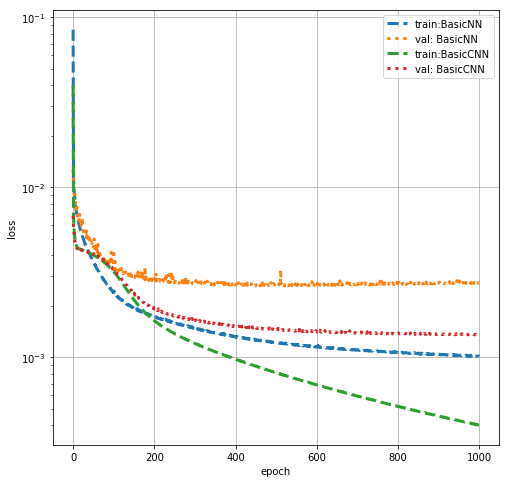

In [32]:
# reload model
model1, history1 = load_model("BasicNN")
model2, history2 = load_model("BasicCNN")

print("======= Output shape at each layer =======")
for layer in model2.layers:
    print(layer.get_output_at(0).get_shape().as_list())
print("======= Model summary =======")
model2.summary()

plt.figure(figsize=(8,8))
plot_loss(history1,"BasicNN",plt)
plot_loss(history2,"BasicCNN",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()